In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Flatten, Dense,Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive

# Mount local disk
drive.mount('/content/local_drive', force_remount=True)


Mounted at /content/local_drive


In [4]:
base_path = r'/content/local_drive/MyDrive/dataset motion sensor/A_DeviceMotion_data/A_DeviceMotion_data'
activity_dataframes = []
activity_folder_names = []
csv_file_names = []
for folderName in os.listdir(base_path):
    activity_folder_names.append(folderName)
    csv_dict = {}
    folder_path = os.path.join(base_path, folderName)
    for csvFileName in os.listdir(folder_path):
        if csvFileName.endswith(".csv"):
            csv_file_names.append(csvFileName)
            csv_path = os.path.join(folder_path, csvFileName)
            df = pd.read_csv(csv_path)
            csv_dict[csvFileName] = df
    activity_dataframes.append(csv_dict)
print(len(activity_dataframes))
corresponding_dfs = {}
for i, folder_name in enumerate(activity_folder_names):
    corresponding_dfs[folder_name] = activity_dataframes[i]


15


In [5]:
df_subject_info = pd.read_csv("/content/local_drive/MyDrive/dataset motion sensor/A_DeviceMotion_data/data_subjects_info.csv")

In [6]:
df_subject_info.describe()

,code,weight,height,age,gender
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,12.500000,72.125000,174.208333,28.791667,0.583333
std,7.071068,16.211409,8.900313,5.437224,0.503610
min,1.000000,48.000000,161.000000,18.000000,0.000000
25%,6.750000,60.000000,164.750000,25.000000,0.000000
50%,12.500000,71.000000,175.500000,28.000000,1.000000
75%,18.250000,80.500000,180.000000,31.250000,1.000000
max,24.000000,102.000000,190.000000,46.000000,1.000000


<Axes: xlabel='age', ylabel='Count'>

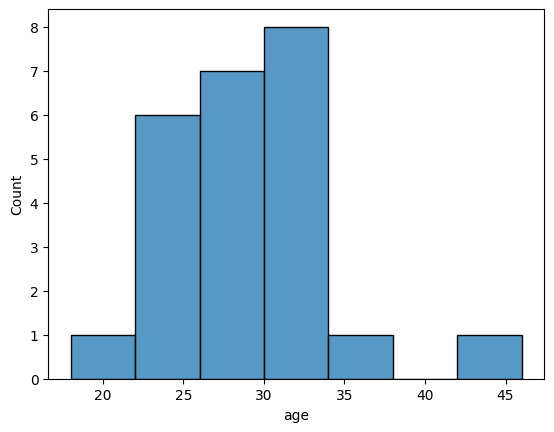

In [7]:
sns.histplot(data=df_subject_info,x = "age")

<Axes: xlabel='height', ylabel='Count'>

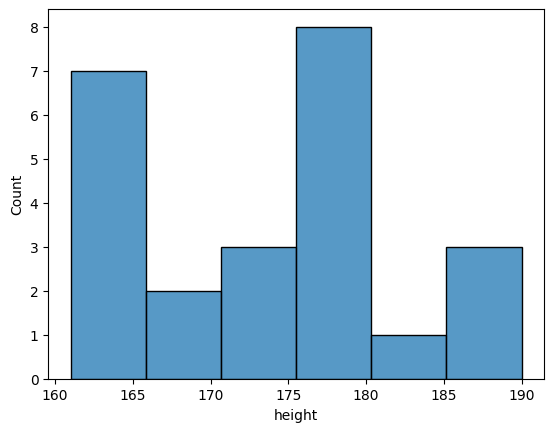

In [8]:
sns.histplot(data=df_subject_info,x="height")

In [9]:
df_subject_info.set_index("code",inplace = True)

In [10]:
combined_df = []
for activity, csv_dict in corresponding_dfs.items():
    for subject, df in csv_dict.items():
        df['activity'] = activity
        combined_df.append(df)
combined_df = pd.concat(combined_df, ignore_index=True)
scaled_df = combined_df.copy()

In [11]:
scaled_df.drop("Unnamed: 0", axis="columns", inplace=True)
scaled_df = scaled_df.round(4)
scaled_df.loc[scaled_df["activity"] == "dws_1", "activity"] = "down stairs"
scaled_df.loc[scaled_df["activity"] == "dws_2", "activity"] = "down stairs"
scaled_df.loc[scaled_df["activity"] == "dws_11", "activity"] = "down stairs"
scaled_df.loc[scaled_df["activity"] == "jog_9", "activity"] = "jogging"
scaled_df.loc[scaled_df["activity"] == "jog_16", "activity"] = "jogging"
scaled_df.loc[scaled_df["activity"] == "sit_5", "activity"] = "sitting"
scaled_df.loc[scaled_df["activity"] == "sit_13", "activity"] = "sitting"
scaled_df.loc[scaled_df["activity"] == "std_6", "activity"] = "standing"
scaled_df.loc[scaled_df["activity"] == "std_14", "activity"] = "standing"
scaled_df.loc[scaled_df["activity"] == "ups_3", "activity"] = "up stairs"
scaled_df.loc[scaled_df["activity"] == "ups_4", "activity"] = "up stairs"
scaled_df.loc[scaled_df["activity"] == "ups_12", "activity"] = "up stairs"
scaled_df.loc[scaled_df["activity"] == "wlk_7", "activity"] = "walking"
scaled_df.loc[scaled_df["activity"] == "wlk_8", "activity"] = "walking"
scaled_df.loc[scaled_df["activity"] == "wlk_15", "activity"] = "walking"

In [12]:
scaled_df.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,activity
0,1.5281,-0.7339,0.6964,0.7419,0.6698,-0.0317,0.3167,0.7782,1.0828,0.2949,-0.1845,0.3775,down stairs
1,1.5280,-0.7170,0.6778,0.7531,0.6571,-0.0323,0.8420,0.4244,0.6436,0.2194,0.0358,0.1149,down stairs
2,1.5278,-0.7070,0.6710,0.7596,0.6496,-0.0327,-0.1381,-0.0407,0.3436,0.0107,0.1347,-0.1678,down stairs
3,1.5168,-0.7047,0.6757,0.7607,0.6478,-0.0411,-0.0250,-1.0487,0.0359,-0.0084,0.1368,0.0950,down stairs
4,1.4939,-0.7039,0.6730,0.7601,0.6472,-0.0585,0.1143,-0.9129,0.0473,0.1994,0.3540,-0.0443,down stairs


In [13]:
scaled_df.shape

(1412865, 13)

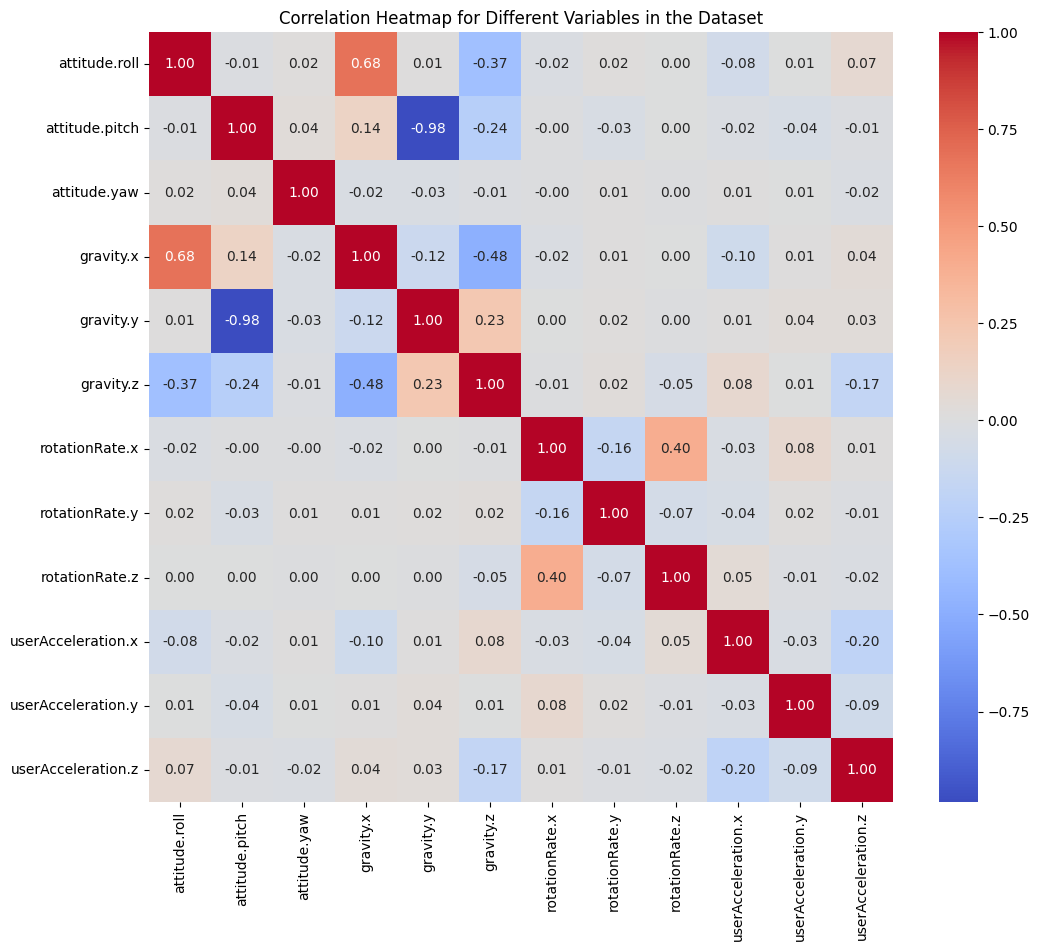

In [14]:
corr_df = scaled_df.drop("activity", axis="columns")
corr_matrix = corr_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(data=corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap for Different Variables in the Dataset")
plt.show()

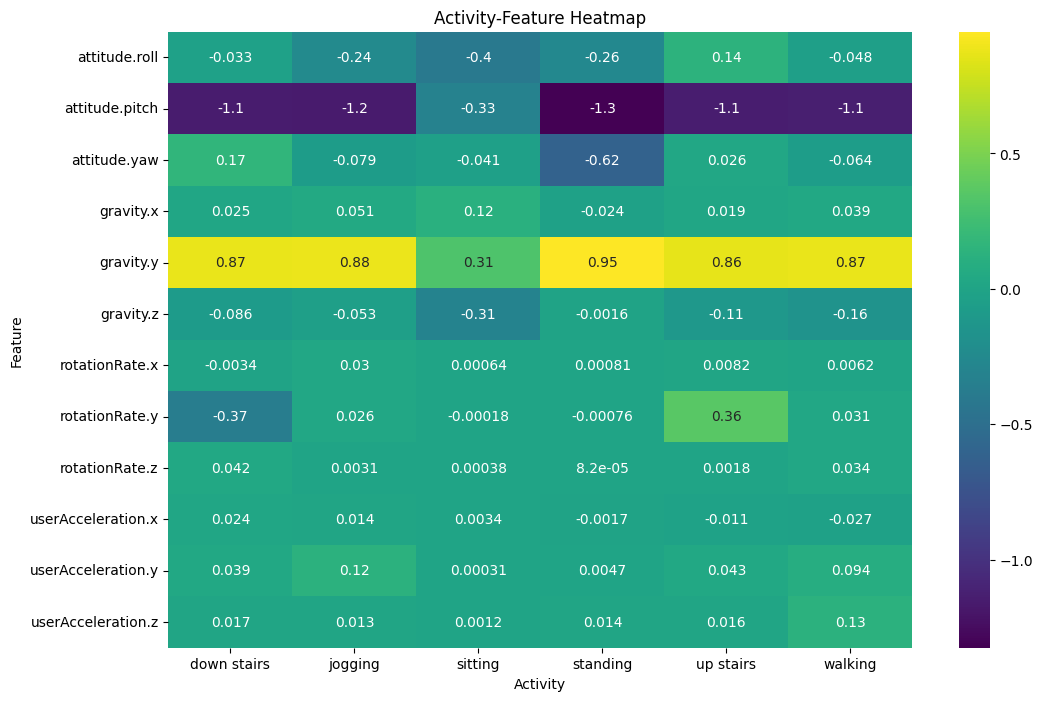

In [15]:
activity_means = scaled_df.groupby('activity').mean()
plt.figure(figsize=(12, 8))
sns.heatmap(activity_means.T, annot=True, cmap="viridis")
plt.title('Activity-Feature Heatmap')
plt.xlabel('Activity')
plt.ylabel('Feature')
plt.show()

In [16]:
scaled_df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,activity
0,1.5281,-0.7339,0.6964,0.7419,0.6698,-0.0317,0.3167,0.7782,1.0828,0.2949,-0.1845,0.3775,down stairs
1,1.5280,-0.7170,0.6778,0.7531,0.6571,-0.0323,0.8420,0.4244,0.6436,0.2194,0.0358,0.1149,down stairs
2,1.5278,-0.7070,0.6710,0.7596,0.6496,-0.0327,-0.1381,-0.0407,0.3436,0.0107,0.1347,-0.1678,down stairs
3,1.5168,-0.7047,0.6757,0.7607,0.6478,-0.0411,-0.0250,-1.0487,0.0359,-0.0084,0.1368,0.0950,down stairs
4,1.4939,-0.7039,0.6730,0.7601,0.6472,-0.0585,0.1143,-0.9129,0.0473,0.1994,0.3540,-0.0443,down stairs


In [17]:
encoder = LabelEncoder()
scaled_df["coded"] = encoder.fit_transform(scaled_df["activity"])
scaled_df.drop("activity",axis = "columns",inplace =True)

In [18]:
scaled_df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,coded
0,1.5281,-0.7339,0.6964,0.7419,0.6698,-0.0317,0.3167,0.7782,1.0828,0.2949,-0.1845,0.3775,0
1,1.5280,-0.7170,0.6778,0.7531,0.6571,-0.0323,0.8420,0.4244,0.6436,0.2194,0.0358,0.1149,0
2,1.5278,-0.7070,0.6710,0.7596,0.6496,-0.0327,-0.1381,-0.0407,0.3436,0.0107,0.1347,-0.1678,0
3,1.5168,-0.7047,0.6757,0.7607,0.6478,-0.0411,-0.0250,-1.0487,0.0359,-0.0084,0.1368,0.0950,0
4,1.4939,-0.7039,0.6730,0.7601,0.6472,-0.0585,0.1143,-0.9129,0.0473,0.1994,0.3540,-0.0443,0


from matplotlib import pyplot as plt
_df_0['attitude.roll'].plot(kind='hist', bins=20, title='attitude.roll')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['attitude.pitch'].plot(kind='hist', bins=20, title='attitude.pitch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['attitude.yaw'].plot(kind='hist', bins=20, title='attitude.yaw')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['gravity.x'].plot(kind='hist', bins=20, title='gravity.x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='attitude.roll', y='attitude.pitch', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='attitude.pitch', y='attitude.yaw', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='attitude.yaw', y='gravity.x', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='gravity.x', y='gravity.y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['attitude.pitch']
  ys = series['attitude.roll']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('attitude.pitch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('attitude.pitch')
_ = plt.ylabel('attitude.roll')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['attitude.pitch']
  ys = series['attitude.yaw']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('attitude.pitch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('attitude.pitch')
_ = plt.ylabel('attitude.yaw')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['attitude.pitch']
  ys = series['gravity.x']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('attitude.pitch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('attitude.pitch')
_ = plt.ylabel('gravity.x')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['attitude.pitch']
  ys = series['gravity.y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('attitude.pitch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('attitude.pitch')
_ = plt.ylabel('gravity.y')

from matplotlib import pyplot as plt
_df_12['attitude.roll'].plot(kind='line', figsize=(8, 4), title='attitude.roll')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['attitude.pitch'].plot(kind='line', figsize=(8, 4), title='attitude.pitch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['attitude.yaw'].plot(kind='line', figsize=(8, 4), title='attitude.yaw')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['gravity.x'].plot(kind='line', figsize=(8, 4), title='gravity.x')
plt.gca().spines[['top', 'right']].set_visible(False)

In [19]:
#scaled_df.drop(["gravity.x","gravity.y","gravity.z"],axis = "columns",inplace = True)
Y = scaled_df["coded"]
X = scaled_df.iloc[:,0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=False)
print(scaled_df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
#standardize the dataset so that it has a mean of 0 and the standard deviation of 1
mean = X_train.mean()
std = X_train.std()
X_train = (X_train-mean)/std
X_test = (X_test - X_test.mean())/X_test.std()

(1412865, 13)
(1130292, 12)
(1130292,)
(282573, 12)
(282573,)


In [20]:
encoder = LabelEncoder()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Print one-hot encoded labels for verification
print("One-hot encoded y_train[5]:", y_train)
print("One-hot encoded y_test[5]:", y_test)

One-hot encoded y_train[5]: [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
One-hot encoded y_test[5]: [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [21]:
print(scaled_df.head())
print(scaled_df.shape)


   attitude.roll  attitude.pitch  attitude.yaw  gravity.x  gravity.y  \
0         1.5281         -0.7339        0.6964     0.7419     0.6698   
1         1.5280         -0.7170        0.6778     0.7531     0.6571   
2         1.5278         -0.7070        0.6710     0.7596     0.6496   
3         1.5168         -0.7047        0.6757     0.7607     0.6478   
4         1.4939         -0.7039        0.6730     0.7601     0.6472   

   gravity.z  rotationRate.x  rotationRate.y  rotationRate.z  \
0    -0.0317          0.3167          0.7782          1.0828   
1    -0.0323          0.8420          0.4244          0.6436   
2    -0.0327         -0.1381         -0.0407          0.3436   
3    -0.0411         -0.0250         -1.0487          0.0359   
4    -0.0585          0.1143         -0.9129          0.0473   

   userAcceleration.x  userAcceleration.y  userAcceleration.z  coded  
0              0.2949             -0.1845              0.3775      0  
1              0.2194              0.035

In [22]:
def make_windows(data,window_size,stride):
  x = []
  y = []
  for i in range(window_size,len(data),stride):
    current_window = data.iloc[i-window_size:i,0:11].values
    x.append(current_window)
    y.append(data.iloc[i, 12])
  return np.array(x),np.array(y)
X,Y = make_windows(scaled_df,200,10)

In [23]:
X.shape,Y.shape

((141267, 200, 11), (141267,))

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(113013, 200, 11)
(113013,)
(28254, 200, 11)
(28254,)


In [26]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128))
model.add(Dense(128,activation="relu"))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
callback = EarlyStopping(monitor='loss',patience=3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               71680     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 96838 (378.27 KB)
Trainable params: 96838 (378.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
model.fit(X_train,y_train,epochs=5,batch_size=64,callbacks=[callback])

Epoch 1/5
1766/1766 [==============================] - 614s 342ms/step - loss: 0.2645 - accuracy: 0.9149
Epoch 2/5
1766/1766 [==============================] - 572s 324ms/step - loss: 0.1007 - accuracy: 0.9725
Epoch 3/5
1766/1766 [==============================] - 570s 323ms/step - loss: 0.0613 - accuracy: 0.9832
Epoch 4/5
1766/1766 [==============================] - 571s 323ms/step - loss: 0.0488 - accuracy: 0.9865
Epoch 5/5
1766/1766 [==============================] - 566s 320ms/step - loss: 0.0430 - accuracy: 0.9874


In [29]:
model.evaluate(X_test,y_test,batch_size=64)

442/442 [==============================] - 57s 129ms/step - loss: 0.0365 - accuracy: 0.9899


[0.036520037800073624, 0.9899129271507263]

In [30]:
model.save("MultivariateTimeSeriesClassification0.keras")

In [32]:
predictions= model.predict(X_test)

883/883 [==============================] - 84s 95ms/step


In [38]:
counter = 0
total = len(predictions)
for i in range(len(predictions)):
  predictor = X_test[i]
  prediction = model.predict(predictor)
  argmax=np.argmax(prediction)


2